This is part two of the Automatic Essay Scoring where it will cover the feature selection, modeling and evaluation.

This notebook is a requirement for CS160P which explores machine learning algorithms with vectorized features from all student essay tests. 

This part shows the following process:
 - Generate vectorized features from the processed essays from part one.
 - Feature Selection and Evaluation
 
     Test of performance through kappa score
        a. Linear Support Vector Classification
        b. Linear Regression
        c. Random Forest
        d. ElasticNet
     Evaluation using ElasticNet with GridSearchCV 


first, we import the modules.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

plt.style.use('seaborn-colorblind')


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

We will now get the essay data that we processed in the previous part. specifically 'training_spacy.pkl'.

In [2]:
training_set = pd.read_pickle('training_spacy.pkl')

check lemmatization, pos tag and entity recognition

In [3]:
training_set[['lemma', 'pos', 'ner']].sample(3)

,lemma,pos,ner
9275,"[allow, a, dirigible, to, dock, upon, the, top, of, the, empire, state, building, ,, would, leav...","[VERB, DET, NOUN, PART, VERB, ADP, DET, NOUN, ADP, DET, PROPN, PROPN, PROPN, PUNCT, VERB, VERB, ...","[the Empire State Building, Siberia, a thousand foot, the U. S, German, Hindenburg, Lusted, Lusted]"
3683,"[in, the, text, ,, the, feature, of, the, setting, greatly, affect, the, cyclist, ., for, exampl...","[ADP, DET, NOUN, PUNCT, DET, NOUN, ADP, DET, NOUN, ADV, VERB, DET, NOUN, PUNCT, ADP, NOUN, PUNCT...","[kind., Secondly, years earlier, GRAPE]"
10433,"[the, architect, could, not, simply, drop, a, mooring, mast, on, top, of, the, empire, state, bu...","[DET, NOUN, VERB, ADV, ADV, VERB, DET, NOUN, NOUN, ADP, NOUN, ADP, DET, PROPN, PROPN, NOUN, ADJ,...","[Empire State, A thousand-foot]"


### Generate vectorized features from processed essays

We will now generate vectorized features by counting various features from the training set.

In [7]:
t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:00:07.245959


In [8]:
training_set.to_pickle('training_features.pkl')

In [9]:
training_set = pd.read_pickle('training_features.pkl')

## Feature Selection

now, we will undergo feature selection to start evaluation

before that, we must check the correlation of the features through plotting...

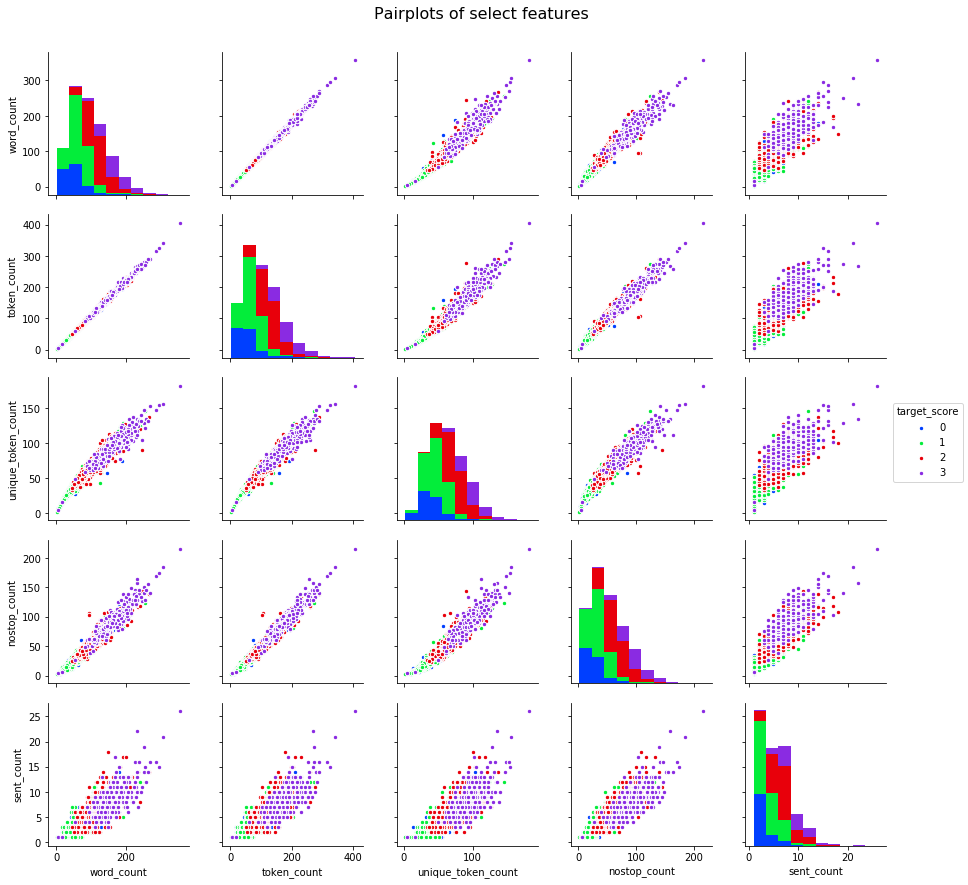

In [10]:
usecols = ['word_count', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count']
g = sns.pairplot(training_set[training_set.topic == 4], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

we would also want to check for incomplete columns to be ignored for modeling.

In [11]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 66 columns):
essay_id              12976 non-null int64
topic                 12976 non-null int64
essay                 12976 non-null object
rater1_domain1        12976 non-null int64
rater2_domain1        12976 non-null int64
rater3_domain1        128 non-null float64
target_score          12976 non-null int64
rater1_domain2        1800 non-null float64
rater2_domain2        1800 non-null float64
topic2_target         1800 non-null float64
rater1_trait1         2292 non-null float64
rater1_trait2         2292 non-null float64
rater1_trait3         2292 non-null float64
rater1_trait4         2292 non-null float64
rater1_trait5         723 non-null float64
rater1_trait6         723 non-null float64
rater2_trait1         2292 non-null float64
rater2_trait2         2292 non-null float64
rater2_trait3         2292 non-null float64
rater2_trait4         2292 non-null float64
rater2_trait5      

In [14]:
# after that, we will now start with the predictors by selecting k best features. 
# some of the features are removed due to high correlation.

predictors = [  
                'word_count',
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

# feature selection
# fvalue_selector = SelectKBest(score_func=f_regression, k=10)

# for use in pipeline
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearSVC', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]
Weighted by topic Kappa score: 0.5751

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]
Weighted by topic Kappa score: 0.7100

[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=26, verbose=0, warm_start=False))]
Weighted by topic Kappa score: 0.6898

[('en', ElasticNet(alpha=0.1, co

Based on the results, three models have similar results but one which returns a poor kappa score.

We can improve the results by adding hyperparameters for ElasticNet by running GridSearchCV on each topic

In [15]:
# ElasticNet with GridSearchCV 
def en_evaluate(df, topic, features):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .3, .5, .7, .99], 'alpha': [0.001, 0.01, 0.1, 1]}
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),
                      param_grid=paramgrid,
                      cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [16]:
kappas = []
weights = []
for topic in range(1,9):
    kappas.append(en_evaluate(training_set, topic, predictors))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 2 best parameters: {'alpha': 1, 'l1_ratio': 0.01}
Topic 3 best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.7}
Topic 5 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 6 best parameters: {'alpha': 0.001, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.001, 'l1_ratio': 0.7}
Topic 8 best parameters: {'alpha': 1, 'l1_ratio': 0.7}
Weighted by topic Kappa score: 0.7135


In [17]:
# Individual topic kappa scores
kappas

[0.8026615360220601,
 0.6453843679639755,
 0.6675004632203076,
 0.6201412784903135,
 0.7983501888241695,
 0.6810744597077609,
 0.733541110264561,
 0.7055995750817732]